## About

Notebook to fetch ECG, calculate HR abd HRV values

In [1]:
root_folder = "./../"
sys.path.insert(1, root_folder)
sys.path.insert(1, os.path.join(root_folder, 'tools/'))

#%%
import sys
import getopt

#Imports
import numpy as np
import multiprocessing # todo
from os.path import join as ospj
import sys
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from tools import get_iEEG_data
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import iirnotch, filtfilt, butter, lfilter, medfilt

import warnings
warnings.filterwarnings("ignore")

import biosppy
from biosppy.signals import ecg
import pyhrv
import pyhrv.tools as tools
from pyhrv.hrv import hrv
import neurokit2 as nk
import heartpy as hp
import pyhrv.time_domain as td 
import pyhrv.frequency_domain as fd

from datetime import datetime, date, timedelta
import importlib

from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt, find_peaks, medfilt, ellip
from scipy.signal import savgol_filter, hilbert
import sys
import os
import json



from helpers import *


    

In [2]:
def remove_std(signal, std_mul=1.5):
    std_rem = signal.copy()
    mean = np.mean(std_rem)
    std = np.std(std_rem)
    std_rem[(std_rem<(mean+std_mul*std)) & (std_rem>(mean-std_mul*std))]=mean
    return std_rem

In [3]:
username = 'jalpanchal'
pwd_bin_path = "/users/jalp/tools/jal_ieeglogin.bin"
with open(pwd_bin_path, "r") as f:
    s = Session(username, f.read())   
    
#import login credentials
from cryptography.fernet import Fernet
import os
 
cred_filename = '/users/jalp/ieeg_credentials/CredFile.ini'
key_file = '/users/jalp/ieeg_credentials/key.key'
 
key = ''
 
with open(key_file,'r') as key_in:
    key = key_in.read().encode()
  
f = Fernet(key)
with open(cred_filename,'r') as cred_in:
    lines = cred_in.readlines()
    config = {}
    for line in lines:
        tuples = line.rstrip('\n').split('=',1)
        if tuples[0] in ('Username','Password'):
            config[tuples[0]] = tuples[1]
 
    password = f.decrypt(config['Password'].encode()).decode()
    user = config['Username']

### Load subject data and seizure timestamps

In [30]:
subject_data = pd.read_csv("./../../data/subject_data.csv")
print(subject_data)

    Unnamed: 0 subject           portal_ID     ecg_channel  ecg_multiplier
0            0  HUP064       HUP64_phaseII    EEG EKG2-Ref               1
1            1  HUP065       HUP65_phaseII  EEG EKG 01-Ref               1
2            2  HUP068       HUP68_phaseII  EEG EKG 02-Ref               1
3            3  HUP070       HUP70_phaseII    EEG EKG2-Ref               1
4            4  HUP073       HUP73_phaseII  EEG EKG 01-Ref              -1
5            5  HUP074       HUP74_phaseII  EEG EKG 02-Ref               1
6            6  HUP075       HUP75_phaseII    EEG EKG2-Ref               1
7            7  HUP078       HUP78_phaseII  EEG EKG 02-Ref               1
8            8  HUP080       HUP80_phaseII  EEG EKG 01-Ref              -1
9            9  HUP083       HUP83_phaseII  EEG EKG 02-Ref               1
10          10  HUP086       HUP86_phaseII  EEG EKG 01-Ref              -1
11          11  HUP087       HUP87_phaseII  EEG EKG 02-Ref               1
12          12  HUP088   

In [31]:
sz_data = pd.read_excel("/users/jalp/git/ecg-ieeg/data/seizure_metadata_with_severity.xlsx")
print(sz_data)

     Unnamed: 0 Patient  Seizure number Seizure type Seizure category  \
0             3  HUP064               0        FBTCS            FBTCS   
1             4  HUP065               0        FBTCS            FBTCS   
2             5  HUP065               1        FBTCS            FBTCS   
3             6  HUP065               2        FBTCS            FBTCS   
4             7  HUP068               0        FBTCS            FBTCS   
..          ...     ...             ...          ...              ...   
251         317  HUP191              10  Subclinical            Other   
252         318  HUP191              11  Subclinical            Other   
253         319  HUP191              12  Subclinical            Other   
254         320  HUP191              13  Subclinical            Other   
255         321  HUP191              14         FIAS            Focal   

     Seizure EEC  Seizure UEO  Seizure end   iEEG Filename  Seizure duration  \
0       632657.0    632666.73     632764.0 

### Calculate data segments
1 min segments, can change to 5 mins
- Segments used from
/users/pattnaik/ecg-ieeg/data/sub-RID0031/all_clip_times.xlsx for each subject has the start and end timiing of each segment\

In [32]:
def calc_hrv_param(data, win_s, overlap_s):
    df = data.copy()

    start =df.index[0]
    stop = df.index[-1]

    hrv_windows = calc_windows(start, stop, win_s, overlap_s)

    hrv_df = pd.DataFrame()
    for i in range(len(hrv_windows)):
        data = df[(df.index >=hrv_windows[i][0]) & (df.index <hrv_windows[i][1])]['heartRate']
        
        if len(data.dropna())>=2:

            nni_ms = 60000/data.values

            #dropping large nni values > 3000 ms
            nni_ms = nni_ms[nni_ms < 3000]



            # print(len(nni_ms))
            # td_results = td.time_domain(nni=nni_ms, rpeaks =rpeaks_ms, sampling_rate=fs,plot=False)
            parameters = ['rmssd', 'hf']

            # hrv_params = np.ones([len(data), len(parameters)])*np.nan
            # hrv_params[-1,0] =  int(td.rmssd(nni=nni_ms)[0])
            rmssd = int(td.rmssd(nni=nni_ms)[0])
            
            #frequency based parameter 
            # try:
            #     freq = fd.welch_psd(nni=nni_ms, show=False, mode='dev')[0]['fft_abs']
            #     hrv_params[-1,1] =  int(freq[2])
            # except : 
            #     hrv_params[-1,1] =  0
            
            hrv_df = hrv_df.append(pd.DataFrame(data={'rmssd' : rmssd, 'hrMean' : round(np.mean(data.values),1) }, index=[data.index[-1]]))

        else:
            continue
    return hrv_df    

def get_hr_hrv(subject_name, start_flag=0, end_flag=0 ):

    sub_data = subject_data[subject_data['subject']==subject_name]

    portal_name = sub_data['portal_ID'].iloc[0]
    # print("portal_name", portal_name)
    ecg_channels = [sub_data['ecg_channel'].iloc[0]]
    ecg_multiplier = sub_data['ecg_multiplier'].iloc[0]


    #Configuring getting  ieeg data
    # print("Getting data for %s" %(subject_name))
    # print("Getting data for %s from IEEG" %(portal_name))

    with open(pwd_bin_path, "r") as f:
        s = Session(username, f.read())
    ds = s.open_dataset(portal_name)

    if start_flag!=0:
        start_time_sec = int(start_flag)
    else:
        start_time_sec = 0

    if end_flag!=0:
        end_time_sec = int(end_flag)
    else:
        end_time_sec = (ds.end_time-ds.start_time)/1e6
    

    # print("time stamps retrived from IEEG")
    # print("Getting data for %s from %d to %d" %(subject_name, start_time_sec, end_time_sec))

    data_pull_min=1

    clip_duration_sec =  end_time_sec - start_time_sec
    clip_duration_min = clip_duration_sec / 60

    # how many data_pull_min minute data pulls are there?
    n_iter = int(np.ceil(clip_duration_min / data_pull_min))


# %%
    
    hr_win = pd.DataFrame()
    for i in range(n_iter):

        start_usec = start_time_sec * 1e6 + i * (data_pull_min * 60 * 1e6)
        if i == n_iter - 1:
            end_usec = end_time_sec * 1e6
        else:
            end_usec = start_usec + (data_pull_min * 60 * 1e6)

        data, fs = get_iEEG_data(username, pwd_bin_path,portal_name , start_usec, end_usec, select_electrodes=ecg_channels)

        time = np.linspace(start_usec, end_usec, len(data), endpoint=False)
        data.index = pd.to_datetime(time, unit='us')


        # format resulting data into pandas DataFrame
        signal_filt = pd.DataFrame(columns=ecg_channels, index=data.index)


        hr_df = pd.DataFrame()
        for n,c in enumerate(ecg_channels):
            #remove baseline wander
            temp_ = hp.remove_baseline_wander(data.iloc[:,n]*ecg_multiplier, fs)


            #bandpas filter
            order = int(0.3 * fs)
            signal_filt[c], _, _ = biosppy.tools.filter_signal(signal=temp_,ftype='FIR',band='bandpass',order=order,frequency=[3,25],sampling_rate=fs)


            # work on 5s samples
            temp_std= pd.DataFrame()
            for i in range(int(len(signal_filt)/int(5*fs))):

                win_data = signal_filt[i*5*int(fs):(i+1)*5*int(fs)][c]

                #remove noise data < 1.5 std

                std_rem = remove_std(win_data, 1.5)
                temp_std = temp_std.append(pd.DataFrame(std_rem))

            try :
            
                out = ecg.ecg(signal=temp_std[c], sampling_rate=fs, show=False)
                # ecg_filtered = out[1]
                # rpeaks = out[2]
                heart_rate_ts = out[-2]
                heart_rate = out[-1]
                idx = (heart_rate_ts*fs).astype(int)

                temp_ = pd.DataFrame(data={c : heart_rate}, index=temp_std.index[idx])
                hr_df = hr_df.append(temp_)

                                
                #shift time to real time
                # hr_df.index = pd.to_datetime(hr_df.index).tz_localize(tz=tz)+ delta

                # resample to 1Hz
                hr_rs = hr_df.resample("1s").mean()   

                #take the min in each 1s window
                hr_min = hr_rs.min(axis=1)

                hr_win = hr_win.append(pd.DataFrame(hr_min.dropna()))
            except:
                    continue  
    # %%
    #smoothen
    hr_sm = pd.DataFrame({'heartRate' : savgol_filter(hr_win[0], 11,3)}, index=hr_win.index)
    hr_sm['heartRate'] = hr_sm['heartRate'].apply(lambda x : round(x,1))


    # %%
    #calc hrv parameters

    # hrv_df = calc_hrv_param(hr_sm, 60,50) #60s window 50s overlap
    hrv_df = calc_hrv_param(hr_sm, 60,0) #60s window 0s overlap

    #combine df and add timestamp column
    combine_df = hr_sm.join(hrv_df)
    combine_df['timestamp'] = (combine_df.index.astype(int)/10e8).astype(int)
    combine_df = combine_df[['timestamp', 'heartRate', 'rmssd', 'hrMean']]

    return combine_df



### Calculating HR, HRV for each Seizure segment

In [33]:
for sub in subject_data['subject'].values[0:1]:

    sz_times = sz_data[sz_data['Patient']==sub]
    # print(sz_times)

    for sz in range(len(sz_times)):
        sz_num = sz_times['Seizure number'].iloc[sz]
        sz_eec  = sz_times['Seizure EEC'].iloc[sz]
        # print(sz_eec)

        
        start_time = int(sz_eec-60*60) #1 hour before eec
        end_time = int(sz_eec)

        file_name = "./../../data/"+sub+"_sz_"+str(sz_num)+"_ecg_hr_hrv"

        # print(file_name)
        # print(start_time, end_time)

        hrv = get_hr_hrv(sub, start_flag=start_time, end_flag=end_time)
        hrv_np = hrv.to_numpy()
        np.save(file_name, hrv_np)



#### Cleaning with sz segment files

In [34]:
files  = [file for file in os.listdir("/users/jalp/git/ecg-ieeg/data") if "sz" in file]
files.sort()

In [35]:
for file in files[0:1]:
    file_path = "/users/jalp/git/ecg-ieeg/data/"+file
    df = pd.DataFrame(np.load(file_path))
    df = df.dropna()
    df = df.drop(columns=[1])
    npy = df.to_numpy()
    np.save(file_path, npy)

#### Calculating Z-score for Sz segments

In [40]:
for sub in tqdm(subject_data['subject']):
    files  = [file for file in os.listdir("/users/jalp/git/ecg-ieeg/data") if sub in file]
    files.sort()
    sz_files  = [file for file in files if "sz" in file]
    inter_files  = [file for file in files if "inter" in file]

    if len(inter_files)==1:
        inter_data  = np.load("/users/jalp/git/ecg-ieeg/data/"+inter_files[0])
        rmssd_mean = np.mean(inter_data[:,1])
        rmssd_std = np.std(inter_data[:,1])

        hr_mean = np.mean(inter_data[:,2])
        hr_std = np.std(inter_data[:,2])

        for file in sz_files:
            # print(sz_files)
            seg_data = np.load("/users/jalp/git/ecg-ieeg/data/"+file)
            # print(seg_data) 

            #calculate z score
            seg_data[:,1] = np.round((seg_data[:,1]-rmssd_mean)/rmssd_std,3)
            seg_data[:,2] = np.round((seg_data[:,2]-hr_mean)/hr_std, 3)

            zscore_file = "/users/jalp/git/ecg-ieeg/data/"+file.replace("sz", "zscore")
            np.save(zscore_file, seg_data)
    else:
        continue

    

100%|██████████| 54/54 [00:08<00:00,  6.73it/s]


### Computing inter-ictal segments

In [24]:
for sub in tqdm(subject_data['subject'].values[24:]):
    # try:
    file_name="/mnt/leif/littlab/users/pattnaik/sz_sev_preictal/data/patients/"+sub+"/interictal_clip_times.npy"
    inter_ictal_times = pd.DataFrame(np.load(file_name))
    hrv =pd.DataFrame()
    for clips in inter_ictal_times.iterrows():
        try: #skips segments with no or insufficient ECG data
            start_time=clips[1].values[0]
            end_time = start_time+60
            print("%s: %s-%s" %(sub, start_time, end_time))

            temp = get_hr_hrv(sub, start_flag=start_time, end_flag=end_time)
            hrv = hrv.append(temp.dropna())
            # print(hrv)
        except Exception as e:
            print(e)
            continue
    file_name = "./../../data/"+sub+"_inter_"+"ecg_hr_hrv"
    hrv_np = hrv.to_numpy()
    #delete HR column
    hrv_np=np.delete(hrv_np, 1,1)
    np.save(file_name, hrv_np)
    # except Exception as e:
    #     print(e)
    #     continue



  0%|          | 0/30 [00:00<?, ?it/s]

HUP126: 281985.81538935564-282045.81538935564
HUP126: 296609.2561089236-296669.2561089236
HUP126: 296611.20709867275-296671.20709867275
HUP126: 317222.8386205491-317282.8386205491
HUP126: 265639.80910272576-265699.80910272576
HUP126: 295980.69943864254-296040.69943864254
HUP126: 306609.09956547874-306669.09956547874
HUP126: 263355.79001996183-263415.79001996183
HUP126: 299329.10449233395-299389.10449233395
HUP126: 319299.70232460165-319359.70232460165
HUP126: 270532.81012152525-270592.81012152525
HUP126: 265028.05906045216-265088.05906045216
HUP126: 293316.27153264923-293376.27153264923
HUP126: 294092.96164520393-294152.96164520393
HUP126: 303573.0805577713-303633.0805577713
HUP126: 304738.6026296264-304798.6026296264
HUP126: 278500.00312465546-278560.00312465546
HUP126: 267503.34941259463-267563.34941259463
HUP126: 268146.11159385584-268206.11159385584
HUP126: 317309.0803203648-317369.0803203648


  3%|▎         | 1/30 [00:28<13:43, 28.40s/it]

HUP130: 341120.50012872193-341180.50012872193
HUP130: 342400.2095082447-342460.2095082447
HUP130: 275588.64796028956-275648.64796028956
HUP130: 338056.4545282986-338116.4545282986
HUP130: 265746.80678957154-265806.80678957154
HUP130: 342034.65853592457-342094.65853592457
HUP130: 341523.66385068523-341583.66385068523
HUP130: 273559.59829738963-273619.59829738963
HUP130: 337691.6932060065-337751.6932060065
HUP130: 342174.9928768973-342234.9928768973
HUP130: 272303.6444227395-272363.6444227395
HUP130: 276290.2530040148-276350.2530040148
HUP130: 339015.7420497412-339075.7420497412
HUP130: 275151.47206948063-275211.47206948063
HUP130: 281050.3735543628-281110.3735543628
HUP130: 262758.39088351646-262818.39088351646
HUP130: 261863.16368866336-261923.16368866336
HUP130: 337769.084796683-337829.084796683
HUP130: 261622.06990249085-261682.06990249085
HUP130: 343928.21778689814-343988.21778689814


  7%|▋         | 2/30 [00:52<11:56, 25.60s/it]

HUP132: 281733.82834219583-281793.82834219583
HUP132: 522249.54305807385-522309.54305807385
HUP132: 495251.59778117866-495311.59778117866
If mode is 'interp', window_length must be less than or equal to the size of x.
HUP132: 526228.4797954091-526288.4797954091
If mode is 'interp', window_length must be less than or equal to the size of x.
HUP132: 280603.6479696546-280663.6479696546
HUP132: 299939.26314946805-299999.26314946805
If mode is 'interp', window_length must be less than or equal to the size of x.
HUP132: 540972.962831453-541032.962831453
If mode is 'interp', window_length must be less than or equal to the size of x.
HUP132: 529074.8972536495-529134.8972536495
HUP132: 330675.8877493432-330735.8877493432
0
HUP132: 336563.4489365533-336623.4489365533
0
HUP132: 349363.9959875968-349423.9959875968
0
HUP132: 502721.23390654835-502781.23390654835
HUP132: 519110.24828492134-519170.24828492134
If mode is 'interp', window_length must be less than or equal to the size of x.
HUP132: 4930

 10%|█         | 3/30 [01:16<11:13, 24.93s/it]

HUP133: 606736.9835239416-606796.9835239416
HUP133: 652691.4299136256-652751.4299136256
HUP133: 620308.6686829315-620368.6686829315
HUP133: 654999.9317696403-655059.9317696403
HUP133: 519704.6934043414-519764.6934043414
HUP133: 512026.84331606416-512086.84331606416
HUP133: 529946.8373756455-530006.8373756455
HUP133: 523551.3289490718-523611.3289490718
HUP133: 523039.4097679622-523099.4097679622
HUP133: 607530.2581131574-607590.2581131574
HUP133: 610475.8379081661-610535.8379081661
HUP133: 507196.90650134214-507256.90650134214
HUP133: 670662.2295589871-670722.2295589871
HUP133: 524372.8863290582-524432.8863290582
HUP133: 507479.2197216793-507539.2197216793
HUP133: 521175.3757830807-521235.3757830807
HUP133: 641882.7322976787-641942.7322976787
HUP133: 508527.50253445806-508587.50253445806
HUP133: 651252.9833625878-651312.9833625878
HUP133: 646015.2166300378-646075.2166300378


 13%|█▎        | 4/30 [01:39<10:35, 24.46s/it]

HUP134: 344828.87605176854-344888.87605176854
0
HUP134: 260366.60508599126-260426.60508599126
0
HUP134: 48023.90286258783-48083.90286258783
HUP134: 17178.92362560275-17238.92362560275
HUP134: 61472.501076790686-61532.501076790686
HUP134: 237601.67387919137-237661.67387919137
0
HUP134: 243873.1694121342-243933.1694121342
0
HUP134: 19769.562637857285-19829.562637857285
HUP134: 41531.28895769819-41591.28895769819
HUP134: 314684.93940239446-314744.93940239446
0
HUP134: 50620.15019470446-50680.15019470446
HUP134: 17728.58078981957-17788.58078981957
HUP134: 312272.1117840538-312332.1117840538
0
HUP134: 238932.30019714983-238992.30019714983
0
HUP134: 26582.696391737976-26642.696391737976
HUP134: 318557.1841035717-318617.1841035717
0
HUP134: 296554.6000392576-296614.6000392576
0
HUP134: 44394.67277229971-44454.67277229971
HUP134: 49020.59740300239-49080.59740300239
HUP134: 303486.3642555103-303546.3642555103


 17%|█▋        | 5/30 [02:06<10:27, 25.09s/it]

0
HUP135: 432646.3973590263-432706.3973590263
HUP135: 416134.03536972846-416194.03536972846
HUP135: 567948.9194135757-568008.9194135757
HUP135: 545685.0585304548-545745.0585304548
HUP135: 438809.1895465329-438869.1895465329
HUP135: 434587.9430535089-434647.9430535089
HUP135: 437048.7783841249-437108.7783841249
HUP135: 543034.6425790954-543094.6425790954
HUP135: 588350.2591756469-588410.2591756469
HUP135: 552655.3999383511-552715.3999383511
HUP135: 446167.73331655876-446227.73331655876
HUP135: 437724.59696764423-437784.59696764423
HUP135: 577247.4989101024-577307.4989101024
HUP135: 417890.6437554266-417950.6437554266
HUP135: 543596.9826461321-543656.9826461321
HUP135: 422510.3564318503-422570.3564318503
HUP135: 416506.73584222-416566.73584222
HUP135: 575611.0377072431-575671.0377072431
HUP135: 570878.3735371277-570938.3735371277
HUP135: 574591.3452313514-574651.3452313514


 20%|██        | 6/30 [02:36<10:43, 26.81s/it]

HUP138: 539776.4897500077-539836.4897500077
HUP138: 609032.0988519411-609092.0988519411
HUP138: 523272.7284469709-523332.7284469709
HUP138: 545936.0719641544-545996.0719641544
HUP138: 541717.0241642513-541777.0241642513
HUP138: 590751.5835127378-590811.5835127378
HUP138: 583202.6708013191-583262.6708013191
HUP138: 611245.6281719282-611305.6281719282
HUP138: 544176.5777356235-544236.5777356235
HUP138: 553290.7829374946-553350.7829374946
HUP138: 582734.03969908-582794.03969908
HUP138: 620498.2123040808-620558.2123040808
HUP138: 544852.0443099263-544912.0443099263
HUP138: 609881.8686566076-609941.8686566076
HUP138: 525028.4218795195-525088.4218795195
HUP138: 603496.5741490182-603556.5741490182
HUP138: 529645.7283163408-529705.7283163408
HUP138: 584942.7874328535-585002.7874328535
HUP138: 605937.8608282922-605997.8608282922
HUP138: 523645.2347933989-523705.2347933989


 23%|██▎       | 7/30 [03:03<10:16, 26.80s/it]

HUP139: 451592.16024130385-451652.16024130385
HUP139: 310665.4323631402-310725.4323631402
HUP139: 337291.64756450197-337351.64756450197
HUP139: 570385.6266109855-570445.6266109855
HUP139: 334490.2889378948-334550.2889378948
HUP139: 311203.1831287914-311263.1831287914
HUP139: 524595.5852479078-524655.5852479078
HUP139: 341817.3677296336-341877.3677296336
HUP139: 533435.3372304491-533495.3372304491
HUP139: 421445.50010707905-421505.50010707905
HUP139: 353999.54449419095-354059.54449419095
HUP139: 343382.27180882066-343442.27180882066
HUP139: 502489.41072144895-502549.41072144895
HUP139: 428394.6736755361-428454.6736755361
HUP139: 340842.2630878302-340902.2630878302
HUP139: 512238.71404813346-512298.71404813346
HUP139: 313199.9542488883-313259.9542488883
HUP139: 527989.1496555156-528049.1496555156
HUP139: 419574.01700645225-419634.01700645225
HUP139: 319865.5053071624-319925.5053071624


 27%|██▋       | 8/30 [03:40<11:02, 30.11s/it]

HUP140: 175533.09850686137-175593.09850686137
HUP140: 172718.78933340168-172778.78933340168
0
HUP140: 302003.8500804714-302063.8500804714
HUP140: 171960.8672573183-172020.8672573183
HUP140: 215867.34035809754-215927.34035809754
HUP140: 281672.06932633027-281732.06932633027
HUP140: 233037.26608275357-233097.26608275357
HUP140: 271565.3897898313-271625.3897898313
HUP140: 209488.65446413113-209548.65446413113
HUP140: 307284.18974447803-307344.18974447803
HUP140: 218072.96315648168-218132.96315648168
HUP140: 270937.97435237345-270997.97435237345
HUP140: 321497.6251352544-321557.6251352544
HUP140: 214492.99859659548-214552.99859659548
HUP140: 184927.72631405585-184987.72631405585
HUP140: 306146.49595679296-306206.49595679296
HUP140: 205540.33549974798-205600.33549974798
HUP140: 273895.10293175816-273955.10293175816
HUP140: 298735.39234789956-298795.39234789956
HUP140: 309110.02624744194-309170.02624744194


 30%|███       | 9/30 [04:10<10:35, 30.24s/it]

HUP142: 691850.1593228648-691910.1593228648
HUP142: 738840.9736515916-738900.9736515916
HUP142: 735131.8232965822-735191.8232965822
HUP142: 754345.2750442326-754405.2750442326
HUP142: 736555.7592454737-736615.7592454737
HUP142: 574764.643759334-574824.643759334
HUP142: 508336.81519499444-508396.81519499444
HUP142: 521782.3333249335-521842.3333249335
HUP142: 511436.1714350148-511496.1714350148
HUP142: 558284.6826770622-558344.6826770622
HUP142: 555855.6635601257-555915.6635601257
HUP142: 729946.8935284201-730006.8935284201
HUP142: 548830.9130049864-548890.9130049864
HUP142: 725856.0964148035-725916.0964148035
HUP142: 544482.688888299-544542.688888299
HUP142: 554342.1217095708-554402.1217095708
HUP142: 507502.12704555044-507562.12704555044
HUP142: 694766.0250235511-694826.0250235511
HUP142: 704499.6652547113-704559.6652547113
HUP142: 691064.8870413807-691124.8870413807


 33%|███▎      | 10/30 [04:33<09:20, 28.01s/it]

HUP144: 280839.40113767015-280899.40113767015
HUP144: 295690.433488904-295750.433488904
HUP144: 580109.1028139027-580169.1028139027
HUP144: 292628.6606292035-292688.6606292035
HUP144: 575384.6134369908-575444.6134369908
HUP144: 564506.9503243768-564566.9503243768
HUP144: 274979.1044379191-275039.1044379191
HUP144: 290733.4652790102-290793.4652790102
HUP144: 296749.1336875165-296809.1336875165
HUP144: 274615.3014100078-274675.3014100078
HUP144: 303932.007609453-303992.007609453
HUP144: 577468.2159139406-577528.2159139406
HUP144: 559549.2278238216-559609.2278238216
HUP144: 589895.2629534277-589955.2629534277
HUP144: 557664.0939359753-557724.0939359753
0
HUP144: 580834.3689143047-580894.3689143047
HUP144: 276329.9744430177-276389.9744430177
HUP144: 581998.3177156517-582058.3177156517
HUP144: 558064.0637280077-558124.0637280077
0
HUP144: 295030.7486611403-295090.7486611403


 37%|███▋      | 11/30 [04:57<08:25, 26.62s/it]

HUP146: 830979.6290664196-831039.6290664196
0
HUP146: 828424.8828278028-828484.8828278028
0
HUP146: 781706.2178174512-781766.2178174512
HUP146: 792587.9016988553-792647.9016988553
0
HUP146: 373022.0693788325-373082.0693788325
HUP146: 404520.0758777397-404580.0758777397
HUP146: 821036.5280253104-821096.5280253104
0
HUP146: 383277.4336841602-383337.4336841602
HUP146: 387378.3185677568-387438.3185677568
HUP146: 848312.6003443833-848372.6003443833
0
HUP146: 335424.66295810626-335484.66295810626
HUP146: 377544.9078834604-377604.9078834604
HUP146: 778446.4375048483-778506.4375048483
HUP146: 816463.2378732015-816523.2378732015
0
HUP146: 826832.999370512-826892.999370512
0
HUP146: 384851.75579276186-384911.75579276186
HUP146: 338648.482008308-338708.482008308
HUP146: 334556.4557083526-334616.4557083526
HUP146: 777568.5455214789-777628.5455214789
HUP146: 349410.12126955384-349470.12126955384


 40%|████      | 12/30 [05:26<08:14, 27.48s/it]

HUP148: 124546.00316504802-124606.00316504802
HUP148: 582795.0782298535-582855.0782298535
HUP148: 98322.37223980442-98382.37223980442
HUP148: 87331.99189183039-87391.99189183039
HUP148: 87974.38739052707-88034.38739052707
HUP148: 551723.0128022056-551783.0128022056
HUP148: 561196.0178060711-561256.0178060711
HUP148: 585410.4395938565-585470.4395938565
HUP148: 579139.1291059777-579199.1291059777
HUP148: 126415.43302098598-126475.43302098598
HUP148: 115793.09617716307-115853.09617716307
HUP148: 552276.716639647-552336.716639647
HUP148: 139098.7960530361-139158.7960530361
HUP148: 90359.72435592295-90419.72435592295
HUP148: 554332.724556904-554392.724556904
HUP148: 119139.5910348474-119199.5910348474
HUP148: 123381.14599949072-123441.14599949072
HUP148: 596342.6874018773-596402.6874018773
HUP148: 583799.1106116943-583859.1106116943
HUP148: 576254.664553475-576314.664553475


 43%|████▎     | 13/30 [05:52<07:38, 26.96s/it]

HUP150: 275714.93533219706-275774.93533219706
HUP150: 278659.24053319526-278719.24053319526
HUP150: 294423.7221754474-294483.7221754474
HUP150: 269082.37237477547-269142.37237477547
HUP150: 295584.15160690236-295644.15160690236
HUP150: 268962.03578492475-269022.03578492475
HUP150: 289955.5253770822-290015.5253770822
HUP150: 295334.1272828589-295394.1272828589
HUP150: 271020.8062696506-271080.8062696506
HUP150: 295985.40503942425-296045.40503942425
HUP150: 276283.33245443064-276343.33245443064
HUP150: 293705.4322945527-293765.4322945527
HUP150: 298707.755351936-298767.755351936
HUP150: 269529.2050761922-269589.2050761922
HUP150: 275933.14193428366-275993.14193428366
HUP150: 274920.3870186658-274980.3870186658
HUP150: 287596.5559697314-287656.5559697314
HUP150: 274293.505634933-274353.505634933
HUP150: 287734.43939877255-287794.43939877255
HUP150: 288246.42685957317-288306.42685957317


 47%|████▋     | 14/30 [06:16<06:57, 26.09s/it]

HUP151: 430857.50033058773-430917.50033058773
HUP151: 655764.3998924355-655824.3998924355
HUP151: 421654.1197862774-421714.1197862774
HUP151: 642458.2627806178-642518.2627806178
HUP151: 442522.4351651905-442582.4351651905
HUP151: 445725.9732640983-445785.9732640983
HUP151: 652579.7612583141-652639.7612583141
HUP151: 642224.5350000797-642284.5350000797
HUP151: 450867.19567643374-450927.19567643374
HUP151: 345148.3505851492-345208.3505851492
HUP151: 656444.5691837624-656504.5691837624
HUP151: 661059.2563932074-661119.2563932074
HUP151: 646223.2510732987-646283.2510732987
HUP151: 343381.6632045062-343441.6632045062
HUP151: 351708.39766501816-351768.39766501816
HUP151: 653797.3426661162-653857.3426661162
HUP151: 373606.9158854878-373666.9158854878
HUP151: 655340.5807957855-655400.5807957855
HUP151: 485748.4136462016-485808.4136462016
HUP151: 643326.1385921525-643386.1385921525


 50%|█████     | 15/30 [06:44<06:39, 26.62s/it]

HUP157: 387968.64674932766-388028.64674932766
HUP157: 457738.61619701615-457798.61619701615
HUP157: 444942.4226454206-445002.4226454206
HUP157: 448540.7504813341-448600.7504813341
HUP157: 379554.96270976716-379614.96270976716
HUP157: 457126.5517119914-457186.5517119914
HUP157: 388391.3045495445-388451.3045495445
HUP157: 456745.1692819956-456805.1692819956
HUP157: 379700.20135966135-379760.20135966135
HUP157: 386746.3156462065-386806.3156462065
HUP157: 455356.4543500645-455416.4543500645
HUP157: 461891.2384726989-461951.2384726989
HUP157: 385989.7094806993-386049.7094806993
HUP157: 380239.5001578312-380299.5001578312
HUP157: 382039.76842027105-382099.76842027105
HUP157: 391258.8752698101-391318.8752698101
HUP157: 445152.74745051726-445212.74745051726
HUP157: 445933.7235522406-445993.7235522406
HUP157: 454260.788393302-454320.788393302
HUP157: 387705.28518719284-387765.28518719284


 53%|█████▎    | 16/30 [07:13<06:23, 27.41s/it]

HUP158: 264848.1564627666-264908.1564627666
HUP158: 464529.04102263646-464589.04102263646
HUP158: 264346.1896015001-264406.1896015001
HUP158: 304796.6912867038-304856.6912867038
HUP158: 292514.94354739017-292574.94354739017
HUP158: 272934.0560149326-272994.0560149326
HUP158: 289200.5989780229-289260.5989780229
HUP158: 293425.16115695453-293485.16115695453
HUP158: 458298.0463951311-458358.0463951311
HUP158: 467131.4377583354-467191.4377583354
HUP158: 465348.90838531905-465408.90838531905
HUP158: 466388.0590878967-466448.0590878967
HUP158: 457556.2735444889-457616.2735444889
HUP158: 460248.8383126914-460308.8383126914
HUP158: 266712.0551233456-266772.0551233456
HUP158: 470238.7712045993-470298.7712045993
HUP158: 294885.9307903764-294945.9307903764
HUP158: 466673.44078212953-466733.44078212953
HUP158: 457713.6558581375-457773.6558581375
HUP158: 286585.6530088119-286645.6530088119


 57%|█████▋    | 17/30 [08:02<07:21, 33.96s/it]

HUP162: 694405.0334301416-694465.0334301416
HUP162: 1052934.56022623-1052994.56022623
HUP162: 689542.6235931197-689602.6235931197
HUP162: 1066510.8146575189-1066570.8146575189
HUP162: 692377.2341610296-692437.2341610296
HUP162: 1044769.0009967699-1044829.0009967699
HUP162: 702881.2633003141-702941.2633003141
HUP162: 693155.70254329-693215.70254329
HUP162: 668715.0694678874-668775.0694678874
HUP162: 675630.5774490035-675690.5774490035
HUP162: 1018817.0156050837-1018877.0156050837
HUP162: 1051847.8686628004-1051907.8686628004
HUP162: 687306.1773444864-687366.1773444864
HUP162: 1047890.9354591522-1047950.9354591522
HUP162: 1054678.5454228178-1054738.5454228178
HUP162: 670309.1785685591-670369.1785685591
HUP162: 1018217.7268772809-1018277.7268772809
HUP162: 1021042.2889114401-1021102.2889114401
HUP162: 1028470.6179236373-1028530.6179236373
HUP162: 668285.7596783026-668345.7596783026


 60%|██████    | 18/30 [08:35<06:44, 33.71s/it]

HUP163: 383746.53097067797-383806.53097067797
HUP163: 392588.7818257439-392648.7818257439
HUP163: 550159.6602070403-550219.6602070403
HUP163: 366097.4774747881-366157.4774747881
HUP163: 516756.49020782846-516816.49020782846
HUP163: 541081.1422175274-541141.1422175274
HUP163: 358053.5521643407-358113.5521643407
HUP163: 519344.18103771214-519404.18103771214
HUP163: 354994.9146160851-355054.9146160851
HUP163: 387127.18462754757-387187.18462754757
HUP163: 517305.52185472933-517365.52185472933
HUP163: 355643.8672618179-355703.8672618179
HUP163: 526149.5613528744-526209.5613528744
HUP163: 543941.2674624698-544001.2674624698
HUP163: 548561.9277281334-548621.9277281334
HUP163: 560999.6609664729-561059.6609664729
HUP163: 394477.2935813278-394537.2935813278
HUP163: 547566.3674396386-547626.3674396386
HUP163: 391412.03457109636-391472.03457109636
HUP163: 407290.119968091-407350.119968091


 63%|██████▎   | 19/30 [09:07<06:03, 33.06s/it]

HUP164: 469896.1464939275-469956.1464939275
HUP164: 531466.3984324225-531526.3984324225
HUP164: 401814.6793069365-401874.6793069365
HUP164: 536742.8434871775-536802.8434871775
HUP164: 429480.756597047-429540.756597047
HUP164: 468779.0588458959-468839.0588458959
HUP164: 454832.3811711646-454892.3811711646
HUP164: 398521.15295289614-398581.15295289614
HUP164: 524090.5860721815-524150.5860721815
HUP164: 474044.10591432045-474104.10591432045
HUP164: 441035.5907019519-441095.5907019519
HUP164: 558798.4590812302-558858.4590812302
HUP164: 487890.6780256685-487950.6780256685
HUP164: 439002.0502321182-439062.0502321182
HUP164: 433121.028364172-433181.028364172
HUP164: 437734.93438917154-437794.93438917154
HUP164: 410476.3397952806-410536.3397952806
HUP164: 399219.94207305985-399279.94207305985
HUP164: 533492.0159126278-533552.0159126278
HUP164: 518271.23011887097-518331.23011887097


 67%|██████▋   | 20/30 [09:43<05:40, 34.07s/it]

HUP166: 537482.5556889344-537542.5556889344
HUP166: 533391.7023930823-533451.7023930823
HUP166: 353936.2254584779-353996.2254584779
HUP166: 502301.20401665696-502361.20401665696
HUP166: 512034.97792779515-512094.97792779515
HUP166: 498600.0152037562-498660.0152037562
HUP166: 359474.8205115467-359534.8205115467
HUP166: 436148.38286922796-436208.38286922796
HUP166: 499385.2982700216-499445.2982700216
HUP166: 443193.79713591014-443253.79713591014
HUP166: 426299.7720920944-426359.7720920944
HUP166: 352444.6254946948-352504.6254946948
HUP166: 472643.72926905414-472703.72926905414
HUP166: 438853.10435230646-438913.10435230646
HUP166: 546376.7579617237-546436.7579617237
HUP166: 542667.5566659434-542727.5566659434
HUP166: 561881.272287514-561941.272287514
HUP166: 544091.5121709025-544151.5121709025
HUP166: 418529.4318287369-418589.4318287369
HUP166: 377963.5635356063-378023.5635356063


 70%|███████   | 21/30 [10:21<05:15, 35.03s/it]

HUP171: 366594.3660407828-366654.3660407828
HUP171: 998151.0934965953-998211.0934965953
HUP171: 1005070.3449109194-1005130.3449109194
HUP171: 354462.3321717836-354522.3321717836
HUP171: 951202.477981258-951262.477981258
HUP171: 362544.94342909567-362604.94342909567
HUP171: 992691.9542257198-992751.9542257198
HUP171: 1030710.5578209015-1030770.5578209015
HUP171: 350778.51302066934-350838.51302066934
HUP171: 364093.15729282785-364153.15729282785
HUP171: 349377.7705794203-349437.7705794203
HUP171: 373327.03310389514-373387.03310389514
HUP171: 946263.3360135128-946323.3360135128
HUP171: 964191.9507315999-964251.9507315999
HUP171: 367459.2343114129-367519.2343114129
HUP171: 1010020.1793324833-1010080.1793324833
HUP171: 366055.4594864092-366115.4594864092
HUP171: 349674.9667979645-349734.9667979645
HUP171: 947311.2762146806-947371.2762146806
HUP171: 1006970.577174194-1007030.577174194


 73%|███████▎  | 22/30 [10:54<04:35, 34.44s/it]

HUP172: 808065.809361188-808125.809361188
HUP172: 771970.3457813207-772030.3457813207
HUP172: 845064.2905281041-845124.2905281041
If mode is 'interp', window_length must be less than or equal to the size of x.
HUP172: 789644.9015889489-789704.9015889489
HUP172: 805393.1853371966-805453.1853371966
HUP172: 776728.1777475283-776788.1777475283
HUP172: 788249.7866950063-788309.7866950063
HUP172: 846369.4416620322-846429.4416620322
HUP172: 788785.3687178909-788845.3687178909
HUP172: 804673.4205125083-804733.4205125083
HUP172: 773067.0841926578-773127.0841926578
HUP172: 848464.0233570412-848524.0233570412
HUP172: 836562.3452916034-836622.3452916034
HUP172: 862674.955077053-862734.955077053
HUP172: 795476.5017460673-795536.5017460673
HUP172: 771674.9829755991-771734.9829755991
HUP172: 816987.468790347-817047.468790347
HUP172: 840311.8878856102-840371.8878856102
HUP172: 784760.9271216984-784820.9271216984
HUP172: 786299.5900053952-786359.5900053952


 77%|███████▋  | 23/30 [11:25<03:54, 33.51s/it]

HUP177: 624119.0317347219-624179.0317347219
HUP177: 591126.1287046396-591186.1287046396
HUP177: 592665.4949927252-592725.4949927252
HUP177: 541724.1418747843-541784.1418747843
HUP177: 552863.704233102-552923.704233102
HUP177: 551072.9516587072-551132.9516587072
HUP177: 615933.8814795048-615993.8814795048
HUP177: 535843.047554104-535903.047554104
HUP177: 611238.4501700585-611298.4501700585
HUP177: 597804.1533433741-597864.1533433741
HUP177: 609078.8050373567-609138.8050373567
HUP177: 614727.453482153-614787.453482153
HUP177: 556757.1011518661-556817.1011518661
HUP177: 613975.7182442781-614035.7182442781
HUP177: 563544.1323494413-563604.1323494413
HUP177: 555756.7451168093-555816.7451168093
HUP177: 537463.2262590562-537523.2262590562
HUP177: 590711.5617111048-590771.5617111048
HUP177: 536186.801673561-536246.801673561
HUP177: 555133.4150186816-555193.4150186816


 80%|████████  | 24/30 [11:54<03:11, 31.99s/it]

HUP181: 216194.22938067943-216254.22938067943
HUP181: 217612.81797277875-217672.81797277875
HUP181: 215310.2951259461-215370.2951259461
HUP181: 209552.2182020947-209612.2182020947
HUP181: 231824.16346772187-231884.16346772187
HUP181: 188442.41148412362-188502.41148412362
HUP181: 251168.0771257654-251228.0771257654
HUP181: 227237.3963165824-227297.3963165824
HUP181: 248357.8138440518-248417.8138440518
HUP181: 190252.4883889485-190312.4883889485
HUP181: 258732.64647685894-258792.64647685894
HUP181: 187954.93936893702-188014.93936893702
HUP181: 233397.9845464297-233457.9845464297
HUP181: 250562.58216127308-250622.58216127308
HUP181: 196294.82339023185-196354.82339023185
HUP181: 246618.29946843488-246678.29946843488
HUP181: 232158.08186662468-232218.08186662468
HUP181: 237536.9840223088-237596.9840223088
HUP181: 252139.81031135345-252199.81031135345
HUP181: 212091.65524679094-212151.65524679094


 83%|████████▎ | 25/30 [12:19<02:30, 30.09s/it]

HUP185: 356356.0530842053-356416.0530842053
HUP185: 789652.4487237697-789712.4487237697
HUP185: 324373.2696552667-324433.2696552667
HUP185: 778777.4483503063-778837.4483503063
HUP185: 364441.6248869495-364501.6248869495
HUP185: 792476.7805672258-792536.7805672258
HUP185: 333222.08211267716-333282.08211267716
HUP185: 378536.52176504105-378596.52176504105
HUP185: 773036.0286359118-773096.0286359118
HUP185: 321722.4680924796-321782.4680924796
HUP185: 791868.254412258-791928.254412258
HUP185: 787904.22610165-787964.22610165
HUP185: 800079.2191854666-800139.2191854666
HUP185: 774617.728477852-774677.728477852
HUP185: 361069.65149484243-361129.65149484243
HUP185: 793453.3783818353-793513.3783818353
HUP185: 321008.5802784827-321068.5802784827
HUP185: 773371.6186759176-773431.6186759176
HUP185: 362364.1458324047-362424.1458324047
HUP185: 352637.1261873774-352697.1261873774


 87%|████████▋ | 26/30 [12:48<01:58, 29.65s/it]

HUP187: 303361.17507551855-303421.17507551855
HUP187: 284035.07383030164-284095.07383030164
HUP187: 297349.85934047605-297409.85934047605
HUP187: 531846.538721089-531906.538721089
HUP187: 293901.45347947243-293961.45347947243
HUP187: 296463.8377797779-296523.8377797779
HUP187: 554902.4423658284-554962.4423658284
HUP187: 557976.9555388904-558036.9555388904
HUP187: 534041.2063425053-534101.2063425053
HUP187: 569369.9759151496-569429.9759151496
HUP187: 552476.7181657886-552536.7181657886
HUP187: 539812.97306851-539872.97306851
HUP187: 278826.15202045266-278886.15202045266
HUP187: 560176.3742653251-560236.3742653251
HUP187: 280261.1543740798-280321.1543740798
HUP187: 532312.1824389054-532372.1824389054
HUP187: 279130.61718159943-279190.61718159943
HUP187: 292315.37278901186-292375.37278901186
HUP187: 558821.3083128366-558881.3083128366
HUP187: 295911.75043585367-295971.75043585367


 90%|█████████ | 27/30 [13:21<01:31, 30.63s/it]

HUP188: 332813.18046163575-332873.18046163575
HUP188: 326291.8699510097-326351.8699510097
HUP188: 451475.4374995405-451535.4374995405
HUP188: 332054.88882906357-332114.88882906357
HUP188: 328096.1486127867-328156.1486127867
HUP188: 449959.0898590136-450019.0898590136
HUP188: 337335.79256825027-337395.79256825027
HUP188: 451273.6384381557-451333.6384381557
HUP188: 333774.28626802866-333834.28626802866
HUP188: 445139.79571028036-445199.79571028036
HUP188: 446932.4735522965-446992.4735522965
HUP188: 334038.2345121909-334098.2345121909
HUP188: 451799.29625356424-451859.29625356424
HUP188: 445028.50755194825-445088.50755194825
HUP188: 325605.8075810297-325665.8075810297
HUP188: 450538.83434716007-450598.83434716007
HUP188: 453996.55342015077-454056.55342015077
HUP188: 445553.0298603-445613.0298603
HUP188: 325751.3697743632-325811.3697743632
HUP188: 334461.83385350875-334521.83385350875


 93%|█████████▎| 28/30 [14:03<01:08, 34.19s/it]

HUP190: 449537.1097215531-449597.1097215531
HUP190: 452750.2841343909-452810.2841343909
HUP190: 425116.9737155032-425176.9737155032
HUP190: 334365.7955805218-334425.7955805218
HUP190: 331807.500160437-331867.500160437
HUP190: 422826.6657876106-422886.6657876106
HUP190: 361643.31636333227-361703.31636333227
HUP190: 373035.86848170345-373095.86848170345
HUP190: 365232.4622961503-365292.4622961503
HUP190: 422209.8625749612-422269.8625749612
HUP190: 386638.88978514494-386698.88978514494
HUP190: 457941.3111225624-458001.3111225624
HUP190: 371030.888091932-371090.888091932
HUP190: 459736.2650774151-459796.2650774151
HUP190: 471914.3377464155-471974.3377464155
HUP190: 331118.52519126487-331178.52519126487
HUP190: 369781.56827048544-369841.56827048544
HUP190: 456822.8605053786-456882.8605053786
HUP190: 342905.80728897284-342965.80728897284
HUP190: 432762.39901181724-432822.39901181724


 97%|█████████▋| 29/30 [14:52<00:38, 38.52s/it]

HUP191: 600704.2581563512-600764.2581563512
HUP191: 635526.0516982643-635586.0516982643
HUP191: 627335.8053476096-627395.8053476096
HUP191: 684686.9930130376-684746.9930130376
HUP191: 603537.3597532397-603597.3597532397
HUP191: 692906.022520307-692966.022520307
HUP191: 610988.1470017248-611048.1470017248
HUP191: 705971.3024294758-706031.3024294758
HUP191: 649143.351528784-649203.351528784
HUP191: 713915.0948362263-713975.0948362263
HUP191: 630467.1784255562-630527.1784255562
HUP191: 634436.0747154808-634496.0747154808
HUP191: 712517.0632248311-712577.0632248311
HUP191: 723400.2019673045-723460.2019673045
HUP191: 601305.358727414-601365.358727414
HUP191: 637275.3095250176-637335.3095250176
HUP191: 711645.9381943644-711705.9381943644
HUP191: 686951.2479045511-687011.2479045511
HUP191: 685167.4010964666-685227.4010964666
HUP191: 708473.9401099182-708533.9401099182


100%|██████████| 30/30 [15:53<00:00, 31.79s/it]


### running HR-HRV for whole dataset

In [11]:
file_name = "./../../data/HUP173/HUP173_ecg_hr_hrv_test"
hrv = get_hr_hrv('HUP173', 0, 100000)
hrv_np = hrv.to_numpy()
np.save(file_name, hrv_np)

  0%|          | 0/334 [00:00<?, ?it/s]

Getting data for 0 to 100000


  2%|▏         | 6/334 [00:18<16:53,  3.09s/it]


KeyboardInterrupt: 

## Load smaple data

In [48]:
file_name = "HUP065_sz_2_ecg_hr_hrv.npy"
file_path = "/mnt/leif/littlab/users/jalp/git/ecg-ieeg/data/"+file_name
test_df = pd.DataFrame(np.load(file_path))
test_df.columns = ['timestamp', 'rmssd', 'hrMean']

### Sample Plot

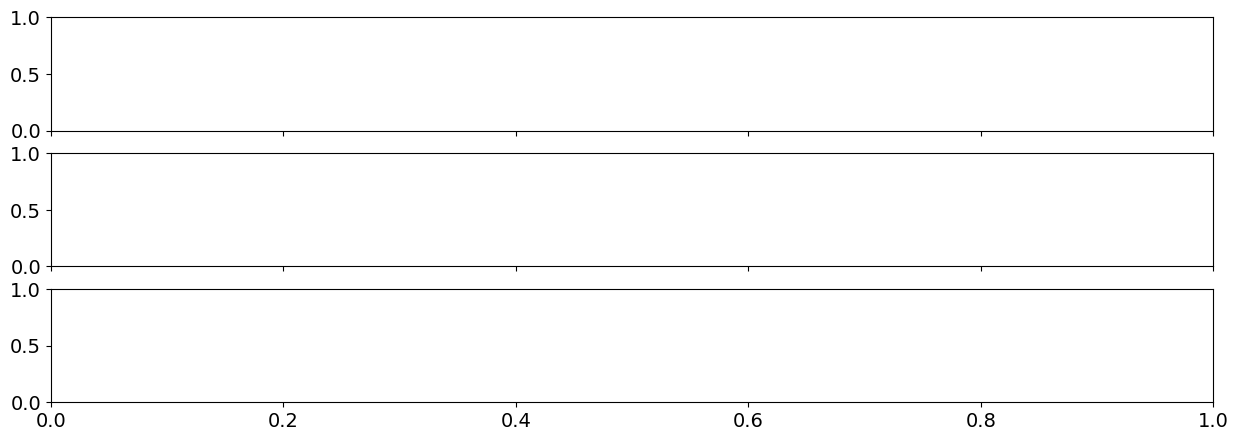

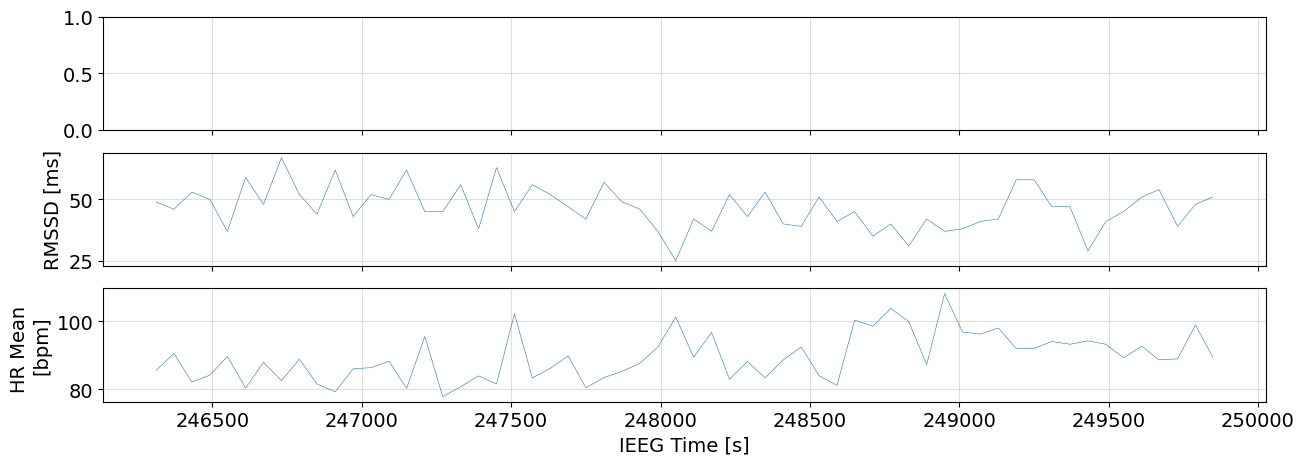

In [50]:
plt.rcParams["font.size"]=14
fig, ax = plt.subplots(3,1, figsize=(15,5), sharex=True)
user_data = test_df.copy()
# axi = ax[0]
# axi.plot(user_data['timestamp'],user_data['heartRate'], '-', lw=0.1)
# axi.set_ylabel("HR [bpm]")
# axi.set_title("File=%s"%(file_name))

data_copy = user_data.copy()
data_copy = data_copy.dropna()

axi = ax[1]
axi.plot(data_copy['timestamp'],data_copy['rmssd'], '-', lw=0.4)
axi.set_ylabel("RMSSD [ms]")
# axi.set_xlabel("IEEG Time [s]")

axi = ax[2]
axi.plot(data_copy['timestamp'],data_copy['hrMean'], '-', lw=0.4)
axi.set_ylabel("HR Mean \n[bpm]")
axi.set_xlabel("IEEG Time [s]")

for axp in ax.flatten():
    axp.grid(alpha=0.4)

plt.show()